# ITINERAIRE DE VACANCE - EXPLORATION DES DONNÉES

## 0. Import des modules

In [243]:
import pandas as pd
import json
from pprint import pprint
import seaborn as sns
import geopandas
import contextily as cx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## 1. Import des données
### 1.1 JSON
#### 1.1.1 Index

In [2]:
objects_path = '../Data/JSON/objects/'

In [3]:
index_path = '../Data/JSON/index.json'

In [4]:
with open(index_path) as json_data:
    index = json.load(json_data)

L'index contient plusieurs informations:
* `file`: chemin d'accès vers les objets json
* `label`: nom du Point Of Interrest
* `lastUpdateDatatourisme`: dernière mise à jour du POI sur Datatourisme

In [5]:
pprint(index[:2])

[{'file': '0/00/13-000fac17-cff9-3918-a3d6-8edc919c8533.json',
  'label': 'Calvi Jet Locations',
  'lastUpdateDatatourisme': '2023-02-22T06:42:37.696Z'},
 {'file': '0/01/13-016f3145-67f8-33c3-9293-109b420a9104.json',
  'label': 'Promenades du Golfe',
  'lastUpdateDatatourisme': '2023-04-02T05:48:09.233Z'}]


#### 1.1.2 Exploration d'un objet json

In [6]:
jsonObject_path = objects_path + index[0]['file']

In [7]:
with open(jsonObject_path) as json_data:
    jsonObject = json.load(json_data)

Nous avons 15 clés dans notre objet json:
* **`@id`: Lien vers le POI.**
* `dc:identifier`: Identifiant unique
* **`@type`: La classification de POI. Par exemple : festival, musée, chambre d’hôtes...**
* `rdfs:comment`: Commentaire du POI
* **`rdfs:label`: Nom du Point Of Interrest**
* `hasBeenCreatedBy`: L'agent qui a créé ce POI dans le système d'information :
    * `@id`: Lien vers l'agent sur DATAtourisme
    * `dc:identifier`: Identifiant unique
    * `schema:email`: E-mail de l'agent
    * `schema:legalName`: Nom officiel de l'agent
    * `@type`: Type de l'agent
    * `foaf:homepage`: Lien vers le site de l'agent
* `hasBeenPublishedBy`: L'agent qui a publié ce POI dans le système d'information:
    * `@id`: Lien vers l'agent sur DATAtourisme
    * `schema:legalName`: Nom officiel de l'agent
    * `@type`: Type de l'agent
    * `foaf:homepage`: Lien vers le site de l'agent
* **`hasContact`: L'agent à contacter pour affaires générales relatives à ce POI:**
    * `@id`: Lien vers l'agent sur DATAtourisme
    * `schema:email`: E-mail de l'agent
    * **`schema:telephone`: Telephone de l'agent**
    * `@type`: Type de l'agent
    * **`foaf:homepage`: Lien vers le site de l'agent**
* **`hasDescription`: Description textuelle courte ou longue du POI pouvant être associée à une audience. Par exemple, un POI peut avoir une description dédiée aux écoles et une autre dédiée au grand public. Si une description n'a aucune audience renseignée, on suppose qu'elle est dédiée à tous les publics:**
    * `@id`: Lien vers la description
    * `@type`: Type(s) de la descripton
    * `hasTranslatedProperty`: Informations de traductions:
        * `@id`: Lien vers les informations de la traduction de la description
        * `dc:contributor`: Traducteur (api.deepl.com/v2/translate)
        * `rdf:language`: Langue de la traduction
        * `rdf:predicate`: Type de la description
    * **`shortDescription`: Dictionnaire des descriptions traduit en plusieurs langues:**
        * `fr`: En fr
        * `de`: ...
* **`hasTheme`: Liste des thèmes:**
    * `@id`: Identifiant du thème au format kb:[theme en anglais sans espace]
    * `@type`: Type du thème
    * `rdfs:label`: Thème en différente langue:
        * `fr`: fr
        * `de`: ...
* `hasTranslatedProperty`: liste d'informations de traductions sur le commentaire:
    * `@id`: Lien vers les informations de la traduction du commentaire
    * `dc:contributor`: Traducteur (api.deepl.com/v2/translate)
    * `rdf:language`: Langue de la traduction
    * `rdf:predicate`: Table de jointure entre @id et comment
* `isLocatedAt`: Informations sur l'emplacement géographique du POI:
    * `@id`: Lien vers les informations sur l'emplacement
    * `schema:address`: Informations sur l'adresse postale
        * `@id`: Lien vers les informations de l'adresse postale
        * **`schema:addressLocality`: Ville**
        * **`schema:postalCode`: Code postale**
        * **`schema:streetAddress`: Adresse postale (certaines données ne sont pas propres)**
        * `@type`: Type de l'adresse
        * `hasAddressCity`: Informations complémentaires sur l'adresse postale
            * `@id`: Identifiant
            * `@type`: Type de localisation (ex: City)
            * **`rdfs:label`: Liste de la ville traduite ['fr']**
            * `insee`: Code Insee
            * `isPartOfDepartment`: Informations du département
                * `@id`: Identifiant
                * `@type`: Type de localisation (ex: Department)
                * **`rdfs:label`: Liste du Department traduite ['fr']**
                * `insee`: Code Insee
                * `isPartOfRegion`: Informations du département:
                    * `@id`: Identifiant
                    * `@type`: Type de localisation (ex: Region)
                    * **`rdfs:label`: Liste de la Region traduite ['fr']**
                    * `insee`: Code Insee
                    * `isPartOfCountry`: Informations du Pays:
                        * `@id`: Identifiant
                        * `@type`: Type de localisation (ex: Country)
                        * **`rdfs:label`: Liste Du Pays traduite ['fr']**
    * `schema:geo`:
        * `@id`: Lien vers les informations coordonnées gépgraphiques
        * **`schema:latitude`: Latitude**
        * **`schema:longitude`: Longitude**
        * `@type`: Type
    * `schema:openingHoursSpecification`: Informations des horraires d'ouverture et fermeture 
        * `@id`: Lien vers les informations des horraires
        * **`schema:closes`: Heure de fermeture**
        * **`schema:opens`: Heure d'ouverture**
        * **`schema:validFrom`: Date de début de période d'ouverture**
        * **`schema:validThrough`: Date de fin de période d'ouverture**
        * `@type`: Type
        * `additionalInformation`: Liste d'inforamtions supplémentaires traduit en plusieurs langues
        * `hasTranslatedProperty`: Liste des informations de traduction des infos supplémentaires
            * `@id`: Lien vers les infos de trad
            * `dc:contributor`: Traducteur (api.deepl.com/v2/translate)
            * `rdf:language`: Langue de la traduction
            * `rdf:predicate`: Table de jointure entre @id et additionalInformation
    * `@type`: Type de place
* `isOwnedBy`: Informations de l'agent propriétaire
    * `@id`: Lien vers l'agent sur DATAtourisme
    * `schema:email`: E-mail de l'agent
    * `schema:legalName`: Nom de l'agent
    * `@type`: Type de l'agent
    * `foaf:homepage`: Lien vers le site de l'agent    
* **`lastUpdate`: Dernière mise à jour du POI**
* `lastUpdateDatatourisme`: Dernière mise à jour du POI sur DATAtourisme

Ce json peut être transformé en JSON-LD grâce au @

In [136]:
pprint(jsonObject)

{'@id': 'https://data.datatourisme.fr/13/ffe728c8-9066-38ff-ac86-e25d3d0bdf87',
 '@type': ['schema:LocalBusiness',
           'PlaceOfInterest',
           'PointOfInterest',
           'SightseeingBoat',
           'SportsAndLeisurePlace'],
 'dc:identifier': '5005873',
 'hasBeenCreatedBy': {'@id': 'https://data.datatourisme.fr/13/e4873aa9-a05c-35ed-8395-61d121516766',
                      '@type': ['schema:Organization', 'foaf:Agent', 'Agent'],
                      'dc:identifier': '1646',
                      'foaf:homepage': ['https://www.balagne-corsica.com/'],
                      'schema:email': ['info@balagne-corsica.com'],
                      'schema:legalName': 'Office de Tourisme Intercommunal '
                                          'Calvi - Balagne'},
 'hasBeenPublishedBy': [{'@id': 'https://data.datatourisme.fr/8a9feb4b-2cbd-3d2c-b507-bd6c6776b23b',
                         '@type': ['schema:Organization',
                                   'foaf:Agent',
         

### 1.2 CSV

In [9]:
csv_path = '../Data/datatourisme-reg-cor-20230406.csv'

In [10]:
df_csv = pd.read_csv(csv_path)

In [11]:
df_csv.head(2)

,Nom_du_POI,Categories_de_POI,Latitude,Longitude,Adresse_postale,Code_postal_et_commune,Periodes_regroupees,Covid19_mesures_specifiques,Covid19_est_en_activite,Covid19_periodes_d_ouvertures_confirmees,Createur_de_la_donnee,SIT_diffuseur,Date_de_mise_a_jour,Contacts_du_POI,Classements_du_POI,Description,URI_ID_du_POI
0,Cala Rossa Bay Resort,https://www.datatourisme.fr/ontology/core#Plac...,41.628354,9.334957,Route de Cala Rossa,20137#Lecci,NaN,NaN,NaN,NaN,Porto Vecchio Tourisme,Apidae Tourisme Scic SA - source : Apidae Tour...,2022-11-07,#+33 7 87 19 07 56#calabayresort@gmail.com#htt...,NaN,Cala Rossa Bay Resort est la promesse d'une ex...,https://data.datatourisme.fr/13/c45810c5-8c12-...
1,U Mulinacciu,https://www.datatourisme.fr/ontology/core#Plac...,41.673547,9.299361,Camping Mulinacciu,20137#Lecci,NaN,NaN,NaN,NaN,Porto Vecchio Tourisme,Apidae Tourisme Scic SA - source : Apidae Tour...,2023-02-21,#+33 4 95 71 47 48#infos@mulinacciu.com#https:...,NaN,Camping entre mer et montagne à 7 kms de Porto...,https://data.datatourisme.fr/13/b26b3595-d776-...


In [12]:
df_csv['SIT_diffuseur'][0]

'Apidae Tourisme Scic SA - source : Apidae Tourisme'

## 2. Préparation des données

In [13]:
listOfPathJson = []
for obj in index:
    listOfPathJson.append(objects_path + obj['file'])

In [14]:
listOfJson = []
for json_path in listOfPathJson:
    with open(json_path) as json_data:
        jsonObject = json.load(json_data)
        listOfJson.append(jsonObject)

len(listOfJson)

623

### 2.1 Sélection des colonnes et Aplatissement du json

In [15]:
col_select_raw = [
    '@id',
    '@type',
    'hasContact',
    'hasDescription',
    'hasTheme',
    'isLocatedAt',
    'lastUpdate'
    ]

In [16]:
df_raw = pd.json_normalize(listOfJson, errors='ignore')[col_select_raw]
df_raw.head(2)

,@id,@type,hasContact,hasDescription,hasTheme,isLocatedAt,lastUpdate
0,https://data.datatourisme.fr/13/000fac17-cff9-...,"[schema:LocalBusiness, ActivityProvider, Place...",[{'@id': 'https://data.datatourisme.fr/d7f7f12...,[{'@id': 'https://data.datatourisme.fr/1759cd3...,"[{'@id': 'kb:SeaKayaking', '@type': ['SportsTh...",[{'@id': 'https://data.datatourisme.fr/f4ee540...,2022-08-11
1,https://data.datatourisme.fr/13/016f3145-67f8-...,"[schema:LocalBusiness, PlaceOfInterest, PointO...",[{'@id': 'https://data.datatourisme.fr/ffcc278...,[{'@id': 'https://data.datatourisme.fr/b120860...,"[{'@id': 'kb:Fishing', '@type': ['SportsTheme'...",[{'@id': 'https://data.datatourisme.fr/91088f9...,2023-04-01


In [17]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   @id             623 non-null    object
 1   @type           623 non-null    object
 2   hasContact      614 non-null    object
 3   hasDescription  604 non-null    object
 4   hasTheme        277 non-null    object
 5   isLocatedAt     623 non-null    object
 6   lastUpdate      623 non-null    object
dtypes: object(7)
memory usage: 34.2+ KB


### 2.2 Preprocessing des données
#### 2.2.1 Type

Plusieurs types sont associés à chaque POI.
On va voir quels types sont important à garder.

In [18]:
df_raw['@type'][0]

['schema:LocalBusiness',
 'ActivityProvider',
 'PlaceOfInterest',
 'PointOfInterest',
 'Store']

In [19]:
df_raw['@type'][1]

['schema:LocalBusiness',
 'PlaceOfInterest',
 'PointOfInterest',
 'SightseeingBoat',
 'SportsAndLeisurePlace']

In [20]:
df_raw['@type'][2]

['schema:LocalBusiness',
 'schema:TouristInformationCenter',
 'LocalTouristOffice',
 'PlaceOfInterest',
 'PointOfInterest',
 'Store',
 'TouristInformationCenter']

In [21]:
occurrences = {}

for liste in df_raw['@type']:
    for el in liste:
        if str(el) in occurrences:
            occurrences[str(el)] += 1
        else:
            occurrences[str(el)] = 1

On remarque :
* Les types les plus courants sont `PointOfInterest` et `PlaceOfInterest`
* Des types contiennent `schema`

PointOfInterest et PlaceOfInterest sont inutiles, on va les supprimer.  
schema: est placé devant un type, pour compter plus exactement le nombre d'occurence nous allons transformer le nom pour que schema n'y apparaisse plus.

In [22]:
count_type = pd.DataFrame(list(occurrences.items()), columns=['Nom', 'Count'])
count_type.sort_values(by="Count", ascending=False).head(5)

,Nom,Count
3,PointOfInterest,623
2,PlaceOfInterest,612
0,schema:LocalBusiness,193
26,FoodEstablishment,185
25,schema:FoodEstablishment,185


Suppression de `PointOfInterest` et `PlaceOfInterest`:

In [23]:
def dropPOI(l):
    output = []
    for el in l:
        if el != 'PlaceOfInterest' and el != 'PointOfInterest':
            output.append(el)
    return output

In [24]:
df_raw['@type'] = df_raw['@type'].map(lambda x: dropPOI(x))

In [25]:
occurrences = {}

for liste in df_raw['@type']:
    for el in liste:
        if str(el) in occurrences:
            occurrences[str(el)] += 1
        else:
            occurrences[str(el)] = 1
            
count_type = pd.DataFrame(list(occurrences.items()), columns=['Nom', 'Count'])
count_type.sort_values(by="Count", ascending=False).head(5)

,Nom,Count
0,schema:LocalBusiness,193
23,schema:FoodEstablishment,185
24,FoodEstablishment,185
10,schema:Accommodation,161
12,Accommodation,161


Suppression de `shema:`

In [26]:
def dropSchema(l):
    output = []
    for el in l:
        if 'schema:' in el:
            output.append(el[7:])
        else:
            output.append(el)
    return output

In [27]:
df_raw['@type'] = df_raw['@type'].map(lambda x: dropSchema(x))

In [28]:
occurrences = {}

for liste in df_raw['@type']:
    for el in liste:
        if str(el) in occurrences:
            occurrences[str(el)] += 1
        else:
            occurrences[str(el)] = 1
            
count_type = pd.DataFrame(list(occurrences.items()), columns=['Nom', 'Count'])
count_type.sort_values(by="Count", ascending=False).head(5)

,Nom,Count
20,FoodEstablishment,370
9,Accommodation,322
0,LocalBusiness,193
10,LodgingBusiness,161
24,Hotel,154


In [29]:
a = ['FoodEstablishment', 'FoodEstablishment', 'test']

In [30]:
output = []
for el in a:
    if el not in output:
        output.append(el)
output

['FoodEstablishment', 'test']

In [31]:
def dropDouble(l):
    output = []
    for el in l:
        if el not in output:
            output.append(el)
    return output

In [32]:
df_raw['@type'] = df_raw['@type'].map(lambda x: dropDouble(x))

In [33]:
occurrences = {}

for liste in df_raw['@type']:
    for el in liste:
        if str(el) in occurrences:
            occurrences[str(el)] += 1
        else:
            occurrences[str(el)] = 1
            
count_type = pd.DataFrame(list(occurrences.items()), columns=['Nom', 'Count'])
count_type.sort_values(by="Count", ascending=False).head(5)

,Nom,Count
0,LocalBusiness,193
20,FoodEstablishment,185
9,Accommodation,161
10,LodgingBusiness,161
2,Store,139


In [34]:
max_ = 0
for el in df_raw['@type']:
    if len(el) > max_:
        max_ = len(el)
max_

7

In [35]:
max_ = {'': 0}

In [36]:
list(max_.values())[0]

0

In [37]:
df_type = df_raw[['@id', '@type']].explode("@type").set_index("@id")
df_type

,@type
@id,
https://data.datatourisme.fr/13/000fac17-cff9-3918-a3d6-8edc919c8533,LocalBusiness
https://data.datatourisme.fr/13/000fac17-cff9-3918-a3d6-8edc919c8533,ActivityProvider
https://data.datatourisme.fr/13/000fac17-cff9-3918-a3d6-8edc919c8533,Store
https://data.datatourisme.fr/13/016f3145-67f8-33c3-9293-109b420a9104,LocalBusiness
https://data.datatourisme.fr/13/016f3145-67f8-33c3-9293-109b420a9104,SightseeingBoat
...,...
https://data.datatourisme.fr/13/ff22bb83-6515-3e5a-bef4-7c19c38d13d9,FoodEstablishment
https://data.datatourisme.fr/13/ffc6590c-e617-33bc-af76-d1f7d487e6fa,FoodEstablishment
https://data.datatourisme.fr/13/ffe728c8-9066-38ff-ac86-e25d3d0bdf87,LocalBusiness


In [38]:
df_lastType = df_raw['@type'].map(lambda x: x[-1])
df_lastType

0                      Store
1      SportsAndLeisurePlace
2                      Store
3               CulturalSite
4              HolidayResort
               ...          
618    SportsAndLeisurePlace
619    SportsAndLeisurePlace
620        FoodEstablishment
621        FoodEstablishment
622    SportsAndLeisurePlace
Name: @type, Length: 623, dtype: object

In [39]:
df_POI = df_raw[['@id']].copy()
df_POI['type'] = df_raw['@type'].map(lambda x: x[-1])
df_POI

,@id,type
0,https://data.datatourisme.fr/13/000fac17-cff9-...,Store
1,https://data.datatourisme.fr/13/016f3145-67f8-...,SportsAndLeisurePlace
2,https://data.datatourisme.fr/13/018c05e0-d6c7-...,Store
3,https://data.datatourisme.fr/13/019b2930-944c-...,CulturalSite
4,https://data.datatourisme.fr/13/0278689c-4ed8-...,HolidayResort
...,...,...
618,https://data.datatourisme.fr/13/fe353538-c261-...,SportsAndLeisurePlace
619,https://data.datatourisme.fr/13/fee026aa-0aa1-...,SportsAndLeisurePlace
620,https://data.datatourisme.fr/13/ff22bb83-6515-...,FoodEstablishment
621,https://data.datatourisme.fr/13/ffc6590c-e617-...,FoodEstablishment


#### 2.2.2 hasContact

Création d'une table contact:

In [40]:
df_contact = pd.DataFrame()
for el in df_raw['hasContact']:
    if type(el) != float:
        df_contact = pd.concat([df_contact, pd.json_normalize(el[0])])
df_contact = df_contact.set_index("@id")
df_contact

,schema:email,schema:telephone,@type,foaf:homepage
@id,,,,
https://data.datatourisme.fr/d7f7f123-e07f-3119-96de-88ac75239c71,[calvijet@gmail.com],[+33 6 26 17 04 97],"[foaf:Agent, Agent]",[https://www.calvi-jet.fr/]
https://data.datatourisme.fr/ffcc2787-f836-3c5e-9bfa-d947c7089ae7,[promenadesdugolfe.ulysse@gmail.com],"[+33 6 15 07 34 68, +33 6 21 09 21 41]","[foaf:Agent, Agent]",[https://www.promenadesdugolfe.com/]
https://data.datatourisme.fr/8943b355-5c02-333a-815b-a44aa97d99d1,[tourisme@balagne-corsica.com],[+33 4 95 65 16 67],"[foaf:Agent, Agent]",[https://www.balagne-corsica.com/]
https://data.datatourisme.fr/4c728769-0f7b-3af4-927c-1364b54b762d,NaN,[+33 4 95 70 09 58],"[foaf:Agent, Agent]",NaN
https://data.datatourisme.fr/6d5b8580-42f1-3ec7-8981-6ccb8f1da905,[infopalombaggia@gmail.com],[+33 4 95 70 95 70],"[foaf:Agent, Agent]",[http://www.palombaggia.com/]
...,...,...,...,...
https://data.datatourisme.fr/363972cc-23a5-3785-b74f-d69626170abe,[panoramic@vacances-andretrigano.com],"[+33 4 95 60 73 13, +33 5 61 69 05 07]","[foaf:Agent, Agent]",[https://vacances-andretrigano.com/camping/hau...
https://data.datatourisme.fr/8bdc849a-057c-3774-b6f6-46e070400896,[info@voce.corsica],"[+33 4 95 61 73 13, +33 6 79 40 68 80]","[foaf:Agent, Agent]",[http://www.voce.corsica/]
https://data.datatourisme.fr/be58956d-3f28-366f-9540-4779179cd77d,[contact@afuntana.fr],[+33 4 95 65 09 52],"[foaf:Agent, Agent]",[http://www.afuntana.fr/]


In [41]:
df_POI['contact'] = df_raw['hasContact'].map(lambda x: x[0]['@id'] if type(x) != float else None)
df_POI.head(5)

,@id,type,contact
0,https://data.datatourisme.fr/13/000fac17-cff9-...,Store,https://data.datatourisme.fr/d7f7f123-e07f-311...
1,https://data.datatourisme.fr/13/016f3145-67f8-...,SportsAndLeisurePlace,https://data.datatourisme.fr/ffcc2787-f836-3c5...
2,https://data.datatourisme.fr/13/018c05e0-d6c7-...,Store,https://data.datatourisme.fr/8943b355-5c02-333...
3,https://data.datatourisme.fr/13/019b2930-944c-...,CulturalSite,https://data.datatourisme.fr/4c728769-0f7b-3af...
4,https://data.datatourisme.fr/13/0278689c-4ed8-...,HolidayResort,https://data.datatourisme.fr/6d5b8580-42f1-3ec...


#### 2.2.3 hasDescription

In [42]:
df_raw['hasDescription'][0][0]

{'@id': 'https://data.datatourisme.fr/1759cd32-f91f-3fda-826a-1c5bc4f7dc1c',
 '@type': ['Description'],
 'hasTranslatedProperty': [{'@id': 'https://data.datatourisme.fr/171d0853-1ebb-37ee-8933-784907bc7565',
   'dc:contributor': ['https://api.deepl.com/v2/translate'],
   'rdf:language': ['es'],
   'rdf:predicate': ['shortDescription']},
  {'@id': 'https://data.datatourisme.fr/3fbb553d-6bd2-36bf-8206-b7dd3b22eced',
   'dc:contributor': ['https://api.deepl.com/v2/translate'],
   'rdf:language': ['nl'],
   'rdf:predicate': ['shortDescription']},
  {'@id': 'https://data.datatourisme.fr/93ec039d-d9ca-31b5-bd6d-75b6eca73687',
   'dc:contributor': ['https://api.deepl.com/v2/translate'],
   'rdf:language': ['de'],
   'rdf:predicate': ['shortDescription']}],
 'shortDescription': {'de': ['Während Ihres Urlaubs auf Korsika können Liebhaber von Wassersport und Nervenkitzel einen unvergesslichen Moment miteinander teilen... in Calvi\r\nVersprechen einer Begegnung mit... Pierre und Ghjulia'],
  'en'

In [43]:
max_ = 0
for el in df_raw['hasDescription']:
    if type(el) != float and len(el) > max_:
        max_ = len(el)
max_

1

In [44]:
max_ = 0
for el in df_raw['hasDescription']:
    if type(el) != float and len(el[0]) > max_:
        max_ = len(el[0])
max_

4

In [45]:
d = {
    "id_description": [],
    "Description": []
}
for el in df_raw['hasDescription']:
    if type(el) != float:
        d['id_description'].append(el[0]['@id'])
        d['Description'].append(el[0]["shortDescription"]["fr"][0])

In [46]:
df_desc = pd.DataFrame(d).set_index("id_description")
df_desc.head(2)

,Description
id_description,
https://data.datatourisme.fr/1759cd32-f91f-3fda-826a-1c5bc4f7dc1c,"Lors de vos vacances en corse, les amateurs de..."
https://data.datatourisme.fr/b1208604-fe24-329e-ab36-c229d8eac59f,Promenades au rythme d'antan à bord d'Ulysse c...


In [47]:
df_POI['description'] = df_raw['hasDescription'].map(lambda x: x[0]['@id'] if type(x) != float else None)
df_POI

,@id,type,contact,description
0,https://data.datatourisme.fr/13/000fac17-cff9-...,Store,https://data.datatourisme.fr/d7f7f123-e07f-311...,https://data.datatourisme.fr/1759cd32-f91f-3fd...
1,https://data.datatourisme.fr/13/016f3145-67f8-...,SportsAndLeisurePlace,https://data.datatourisme.fr/ffcc2787-f836-3c5...,https://data.datatourisme.fr/b1208604-fe24-329...
2,https://data.datatourisme.fr/13/018c05e0-d6c7-...,Store,https://data.datatourisme.fr/8943b355-5c02-333...,https://data.datatourisme.fr/a2407589-9634-30a...
3,https://data.datatourisme.fr/13/019b2930-944c-...,CulturalSite,https://data.datatourisme.fr/4c728769-0f7b-3af...,https://data.datatourisme.fr/91644091-022c-330...
4,https://data.datatourisme.fr/13/0278689c-4ed8-...,HolidayResort,https://data.datatourisme.fr/6d5b8580-42f1-3ec...,https://data.datatourisme.fr/6a7692f9-df41-3c8...
...,...,...,...,...
618,https://data.datatourisme.fr/13/fe353538-c261-...,SportsAndLeisurePlace,https://data.datatourisme.fr/8bdc849a-057c-377...,https://data.datatourisme.fr/27f49b99-fbbc-3cd...
619,https://data.datatourisme.fr/13/fee026aa-0aa1-...,SportsAndLeisurePlace,None,https://data.datatourisme.fr/0d3456f7-d693-3aa...
620,https://data.datatourisme.fr/13/ff22bb83-6515-...,FoodEstablishment,https://data.datatourisme.fr/be58956d-3f28-366...,https://data.datatourisme.fr/a1be4899-99d2-354...
621,https://data.datatourisme.fr/13/ffc6590c-e617-...,FoodEstablishment,https://data.datatourisme.fr/6fccd2d2-8e61-303...,https://data.datatourisme.fr/50f30f9a-720a-3e7...


#### 2.2.4 hasTheme

In [48]:
max_ = 0
for el in df_raw['hasTheme']:
    if type(el) != float and len(el) > max_:
        max_ = len(el)
max_

14

In [49]:
df_theme = pd.DataFrame()
for el in df_raw['hasTheme']:
    if type(el) != float:
        df_theme = pd.concat([df_theme, pd.json_normalize(el)]).drop_duplicates(['@id'])
df_theme_unique = df_theme.set_index("@id")[['@type', 'rdfs:label.fr']]
df_theme_unique

,@type,rdfs:label.fr
@id,,
kb:SeaKayaking,[SportsTheme],[Kayak de mer]
kb:StandupPaddleboarding,[SportsTheme],[Stand up paddle sup]
kb:TowableTube,[SportsTheme],[Bouée tractée]
kb:Wakeboarding,[SportsTheme],[Wake board]
kb:WaterSkiing,[SportsTheme],[Ski nautique]
...,...,...
kb:Tennis,[SportsTheme],[Tennis]
kb:Skydiving,[SportsTheme],[Parachutisme]
kb:Kitesurfing,[SportsTheme],[Kite-surf]


In [50]:
df_theme = df_raw[['@id', 'hasTheme']].copy()
df_theme

,@id,hasTheme
0,https://data.datatourisme.fr/13/000fac17-cff9-...,"[{'@id': 'kb:SeaKayaking', '@type': ['SportsTh..."
1,https://data.datatourisme.fr/13/016f3145-67f8-...,"[{'@id': 'kb:Fishing', '@type': ['SportsTheme'..."
2,https://data.datatourisme.fr/13/018c05e0-d6c7-...,NaN
3,https://data.datatourisme.fr/13/019b2930-944c-...,"[{'@id': 'kb:Culture', '@type': ['CulturalThem..."
4,https://data.datatourisme.fr/13/0278689c-4ed8-...,NaN
...,...,...
618,https://data.datatourisme.fr/13/fe353538-c261-...,NaN
619,https://data.datatourisme.fr/13/fee026aa-0aa1-...,"[{'@id': 'kb:Bathing', '@type': ['Accommodatio..."
620,https://data.datatourisme.fr/13/ff22bb83-6515-...,"[{'@id': 'kb:MediterraneanCuisine', '@type': [..."
621,https://data.datatourisme.fr/13/ffc6590c-e617-...,"[{'@id': 'kb:MediterraneanCuisine', '@type': [..."


In [51]:
df_theme['theme'] = df_raw['hasTheme'].map(lambda x: [el['@id'] for el in x] if type(x) != float else None)
df_theme = df_theme[['@id', 'theme']]
df_theme = df_theme.explode('theme')
df_theme

,@id,theme
0,https://data.datatourisme.fr/13/000fac17-cff9-...,kb:SeaKayaking
0,https://data.datatourisme.fr/13/000fac17-cff9-...,kb:StandupPaddleboarding
0,https://data.datatourisme.fr/13/000fac17-cff9-...,kb:TowableTube
0,https://data.datatourisme.fr/13/000fac17-cff9-...,kb:Wakeboarding
0,https://data.datatourisme.fr/13/000fac17-cff9-...,kb:WaterSkiing
...,...,...
618,https://data.datatourisme.fr/13/fe353538-c261-...,None
619,https://data.datatourisme.fr/13/fee026aa-0aa1-...,kb:Bathing
620,https://data.datatourisme.fr/13/ff22bb83-6515-...,kb:MediterraneanCuisine
621,https://data.datatourisme.fr/13/ffc6590c-e617-...,kb:MediterraneanCuisine


#### 2.2.4 isLocatedAt

In [52]:
max_ = 0
for el in df_raw['isLocatedAt']:
    if type(el) != float and len(el[0]) > max_:
        max_ = len(el)
max_

1

In [53]:
df_location = pd.DataFrame()
for el in df_raw['isLocatedAt']:
    if type(el) != float:
        df_location = pd.concat([df_location, pd.json_normalize(el[0])])
df_location = df_location.set_index("@id")
df_location.head(2)

,schema:address,schema:openingHoursSpecification,@type,schema:geo.@id,schema:geo.schema:latitude,schema:geo.schema:longitude,schema:geo.@type
@id,,,,,,,
https://data.datatourisme.fr/f4ee540b-472b-3f4f-b072-5ba6b244a4f5,[{'@id': 'https://data.datatourisme.fr/7a9ea23...,[{'@id': 'https://data.datatourisme.fr/1e93810...,"[schema:Place, Place]",https://data.datatourisme.fr/7b0e4362-6ce5-302...,42.555104,8.761533,[schema:GeoCoordinates]
https://data.datatourisme.fr/91088f9a-bf80-3b39-a590-e148d2a888a4,[{'@id': 'https://data.datatourisme.fr/e801a89...,[{'@id': 'https://data.datatourisme.fr/f87e535...,"[schema:Place, Place]",https://data.datatourisme.fr/e789100a-05dc-322...,41.590132,9.283183,[schema:GeoCoordinates]


Aplatissement Adresse:

In [54]:
d ={"id_adresse": [],
    "Ville": [],
    "CodePostale": [],
    "Departement": [],
    "Region": []}

for el in df_location['schema:address']:
    id_adresse = el[0]['@id']
    ville = el[0]['schema:addressLocality']
    cp = el[0]['schema:postalCode']
    dep = el[0]['hasAddressCity']['isPartOfDepartment']['rdfs:label']['fr']
    reg = el[0]['hasAddressCity']['isPartOfDepartment']['isPartOfRegion']['rdfs:label']['fr']
    d['id_adresse'].append(id_adresse)
    d['Ville'].append(ville)
    d['CodePostale'].append(cp)
    d['Departement'].append(dep[0])
    d['Region'].append(reg[0])

In [55]:
df_adresse = pd.DataFrame(d).set_index("id_adresse")
df_adresse.head(2)

,Ville,CodePostale,Departement,Region
id_adresse,,,,
https://data.datatourisme.fr/7a9ea23e-6919-3616-a306-b03922fc920c,Calvi,20260,Haute-Corse,Corse
https://data.datatourisme.fr/e801a89e-7e7c-37a6-9098-5990c9cdc79d,Porto-Vecchio,20137,Corse-du-Sud,Corse


In [56]:
def id_adresse(l):
    output = []
    for el in l:
        output.append(el[0][0]['@id'])
    return output

In [57]:
df_location['id_adresse'] = df_location['schema:address'].map(lambda x: x[0]['@id'])

In [58]:
df_location = df_location.join(df_adresse, how='left', on='id_adresse')
df_location

,schema:address,schema:openingHoursSpecification,@type,schema:geo.@id,schema:geo.schema:latitude,schema:geo.schema:longitude,schema:geo.@type,id_adresse,Ville,CodePostale,Departement,Region
@id,,,,,,,,,,,,
https://data.datatourisme.fr/f4ee540b-472b-3f4f-b072-5ba6b244a4f5,[{'@id': 'https://data.datatourisme.fr/7a9ea23...,[{'@id': 'https://data.datatourisme.fr/1e93810...,"[schema:Place, Place]",https://data.datatourisme.fr/7b0e4362-6ce5-302...,42.555104,8.761533,[schema:GeoCoordinates],https://data.datatourisme.fr/7a9ea23e-6919-361...,Calvi,20260,Haute-Corse,Corse
https://data.datatourisme.fr/91088f9a-bf80-3b39-a590-e148d2a888a4,[{'@id': 'https://data.datatourisme.fr/e801a89...,[{'@id': 'https://data.datatourisme.fr/f87e535...,"[schema:Place, Place]",https://data.datatourisme.fr/e789100a-05dc-322...,41.590132,9.283183,[schema:GeoCoordinates],https://data.datatourisme.fr/e801a89e-7e7c-37a...,Porto-Vecchio,20137,Corse-du-Sud,Corse
https://data.datatourisme.fr/91088f9a-bf80-3b39-a590-e148d2a888a4,[{'@id': 'https://data.datatourisme.fr/e801a89...,[{'@id': 'https://data.datatourisme.fr/f87e535...,"[schema:Place, Place]",https://data.datatourisme.fr/e789100a-05dc-322...,41.590132,9.283183,[schema:GeoCoordinates],https://data.datatourisme.fr/e801a89e-7e7c-37a...,Porto-Vecchio,20137,Corse-du-Sud,Corse
https://data.datatourisme.fr/a768f988-5728-32d0-92ea-ada17494246a,[{'@id': 'https://data.datatourisme.fr/3044cc4...,[{'@id': 'https://data.datatourisme.fr/d7943cb...,"[schema:Place, Place]",https://data.datatourisme.fr/9642f3f8-d11e-398...,42.568,8.7595,[schema:GeoCoordinates],https://data.datatourisme.fr/3044cc40-2560-3a0...,Calvi,20260,Haute-Corse,Corse
https://data.datatourisme.fr/a768f988-5728-32d0-92ea-ada17494246a,[{'@id': 'https://data.datatourisme.fr/3044cc4...,[{'@id': 'https://data.datatourisme.fr/d7943cb...,"[schema:Place, Place]",https://data.datatourisme.fr/9642f3f8-d11e-398...,42.568,8.7595,[schema:GeoCoordinates],https://data.datatourisme.fr/3044cc40-2560-3a0...,Calvi,20260,Haute-Corse,Corse
...,...,...,...,...,...,...,...,...,...,...,...,...
https://data.datatourisme.fr/69557782-cb00-3988-bd95-519798ad90a3,[{'@id': 'https://data.datatourisme.fr/83f361d...,[{'@id': 'https://data.datatourisme.fr/77e5d8c...,"[schema:Place, Place]",https://data.datatourisme.fr/8c2d861f-9aeb-36e...,42.627,8.9058,[schema:GeoCoordinates],https://data.datatourisme.fr/83f361d2-cd6c-33e...,Corbara,20220,Haute-Corse,Corse
https://data.datatourisme.fr/69557782-cb00-3988-bd95-519798ad90a3,[{'@id': 'https://data.datatourisme.fr/83f361d...,[{'@id': 'https://data.datatourisme.fr/77e5d8c...,"[schema:Place, Place]",https://data.datatourisme.fr/8c2d861f-9aeb-36e...,42.627,8.9058,[schema:GeoCoordinates],https://data.datatourisme.fr/83f361d2-cd6c-33e...,Corbara,20220,Haute-Corse,Corse
https://data.datatourisme.fr/e837a797-2355-3056-ad72-e8e8cbb61e11,[{'@id': 'https://data.datatourisme.fr/12b01f2...,[{'@id': 'https://data.datatourisme.fr/6076809...,"[schema:Place, Place]",https://data.datatourisme.fr/194ec292-c40e-355...,42.566999,8.757473,[schema:GeoCoordinates],https://data.datatourisme.fr/12b01f21-adb8-366...,Calvi,20260,Haute-Corse,Corse


Aplatissement openingHoursSpecification:

In [59]:
d ={"id_opening": [],
    "Close": [],
    "Open": [],
    "validFrom": [],
    "validThrough": []}

for el in df_location['schema:openingHoursSpecification']:
    id_opening = el[0]['@id']
    try:
        Close = el[0]['schema:closes']
    except:
        Close = None
    try:
        Open = el[0]['schema:opens']
    except:
        Open = None
    try:
        validFrom = el[0]['schema:validFrom']
    except:
        validFrom = None
    try:
        validThrough = el[0]['schema:validThrough']
    except:
        validThrough = None
    d['id_opening'].append(id_opening)
    d['Close'].append(Close)
    d['Open'].append(Open)
    d['validFrom'].append(validFrom)
    d['validThrough'].append(validThrough)

In [60]:
df_opening = pd.DataFrame(d).set_index("id_opening")
df_opening.head(2)

,Close,Open,validFrom,validThrough
id_opening,,,,
https://data.datatourisme.fr/1e938103-b4b8-3327-86b8-9678c3e1a4f4,20:30:00,08:00:00,2023-05-01T00:00:00,2023-10-31T23:59:59
https://data.datatourisme.fr/f87e535a-636d-3343-ad63-8a03392e7511,None,None,2023-01-01T00:00:00,2023-12-31T23:59:59


In [61]:
df_location['id_opening'] = df_location['schema:openingHoursSpecification'].map(lambda x: x[0]['@id'])

In [62]:
df_location = df_location.join(df_opening, how='left', on='id_opening')
df_location.head(2)

,schema:address,schema:openingHoursSpecification,@type,schema:geo.@id,schema:geo.schema:latitude,schema:geo.schema:longitude,schema:geo.@type,id_adresse,Ville,CodePostale,Departement,Region,id_opening,Close,Open,validFrom,validThrough
@id,,,,,,,,,,,,,,,,,
https://data.datatourisme.fr/f4ee540b-472b-3f4f-b072-5ba6b244a4f5,[{'@id': 'https://data.datatourisme.fr/7a9ea23...,[{'@id': 'https://data.datatourisme.fr/1e93810...,"[schema:Place, Place]",https://data.datatourisme.fr/7b0e4362-6ce5-302...,42.555104,8.761533,[schema:GeoCoordinates],https://data.datatourisme.fr/7a9ea23e-6919-361...,Calvi,20260,Haute-Corse,Corse,https://data.datatourisme.fr/1e938103-b4b8-332...,20:30:00,08:00:00,2023-05-01T00:00:00,2023-10-31T23:59:59
https://data.datatourisme.fr/91088f9a-bf80-3b39-a590-e148d2a888a4,[{'@id': 'https://data.datatourisme.fr/e801a89...,[{'@id': 'https://data.datatourisme.fr/f87e535...,"[schema:Place, Place]",https://data.datatourisme.fr/e789100a-05dc-322...,41.590132,9.283183,[schema:GeoCoordinates],https://data.datatourisme.fr/e801a89e-7e7c-37a...,Porto-Vecchio,20137,Corse-du-Sud,Corse,https://data.datatourisme.fr/f87e535a-636d-334...,None,None,2023-01-01T00:00:00,2023-12-31T23:59:59


In [63]:
df_location.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175185 entries, https://data.datatourisme.fr/f4ee540b-472b-3f4f-b072-5ba6b244a4f5 to https://data.datatourisme.fr/96ebe3e4-aaa9-357e-81ab-abeff6395c90
Data columns (total 17 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   schema:address                    175185 non-null  object
 1   schema:openingHoursSpecification  175185 non-null  object
 2   @type                             175185 non-null  object
 3   schema:geo.@id                    175185 non-null  object
 4   schema:geo.schema:latitude        175185 non-null  object
 5   schema:geo.schema:longitude       175185 non-null  object
 6   schema:geo.@type                  175185 non-null  object
 7   id_adresse                        175185 non-null  object
 8   Ville                             175185 non-null  object
 9   CodePostale                       175185 non-null  object
 10  Departemen

In [64]:
df_location_clean = df_location[[
    "schema:geo.schema:latitude",
    "schema:geo.schema:longitude",
    "Ville",
    "CodePostale",
    "Departement",
    "Region",
    "Close",
    "Open",
    "validFrom",
    "validThrough",
]]
df_location_clean.head(2)

,schema:geo.schema:latitude,schema:geo.schema:longitude,Ville,CodePostale,Departement,Region,Close,Open,validFrom,validThrough
@id,,,,,,,,,,
https://data.datatourisme.fr/f4ee540b-472b-3f4f-b072-5ba6b244a4f5,42.555104,8.761533,Calvi,20260,Haute-Corse,Corse,20:30:00,08:00:00,2023-05-01T00:00:00,2023-10-31T23:59:59
https://data.datatourisme.fr/91088f9a-bf80-3b39-a590-e148d2a888a4,41.590132,9.283183,Porto-Vecchio,20137,Corse-du-Sud,Corse,None,None,2023-01-01T00:00:00,2023-12-31T23:59:59


In [65]:
df_POI['location'] = df_raw['isLocatedAt'].map(lambda x: x[0]['@id'])

In [66]:
df_POI['lastUpdate'] = df_raw['lastUpdate']

#### 2.2.5 DF_POI

In [67]:
df_POI = df_POI.join(df_contact, on='contact', how='left') \
               .drop_duplicates(subset='@id') \
               .drop(columns=['contact'])

In [68]:
df_POI = df_POI.join(df_desc, on='description', how='left') \
               .drop_duplicates(subset='@id') \
               .drop(columns=['description'])

In [69]:
df_POI = df_POI.join(df_location_clean, on='location', how='left') \
               .drop_duplicates(subset='@id') \
               .drop(columns=['location'])

In [70]:
df_POI = df_POI.rename(columns={'@type': 'typeContact'})

In [71]:
df_POI.head(5)

,@id,type,lastUpdate,schema:email,schema:telephone,typeContact,foaf:homepage,Description,schema:geo.schema:latitude,schema:geo.schema:longitude,Ville,CodePostale,Departement,Region,Close,Open,validFrom,validThrough
0,https://data.datatourisme.fr/13/000fac17-cff9-...,Store,2022-08-11,[calvijet@gmail.com],[+33 6 26 17 04 97],"[foaf:Agent, Agent]",[https://www.calvi-jet.fr/],"Lors de vos vacances en corse, les amateurs de...",42.555104,8.761533,Calvi,20260,Haute-Corse,Corse,20:30:00,08:00:00,2023-05-01T00:00:00,2023-10-31T23:59:59
1,https://data.datatourisme.fr/13/016f3145-67f8-...,SportsAndLeisurePlace,2023-04-01,[promenadesdugolfe.ulysse@gmail.com],"[+33 6 15 07 34 68, +33 6 21 09 21 41]","[foaf:Agent, Agent]",[https://www.promenadesdugolfe.com/],Promenades au rythme d'antan à bord d'Ulysse c...,41.590132,9.283183,Porto-Vecchio,20137,Corse-du-Sud,Corse,None,None,2023-01-01T00:00:00,2023-12-31T23:59:59
2,https://data.datatourisme.fr/13/018c05e0-d6c7-...,Store,2022-07-06,[tourisme@balagne-corsica.com],[+33 4 95 65 16 67],"[foaf:Agent, Agent]",[https://www.balagne-corsica.com/],"En saison, le Bureau d'Information Touristique...",42.568,8.7595,Calvi,20260,Haute-Corse,Corse,None,None,2023-06-06T00:00:00,2023-09-30T23:59:59
3,https://data.datatourisme.fr/13/019b2930-944c-...,CulturalSite,2022-05-20,NaN,[+33 4 95 70 09 58],"[foaf:Agent, Agent]",NaN,"Forteresse cyclopéenne, aux remparts démesurés...",41.656311,9.279691,San-Gavino-di-Carbini,20170,Corse-du-Sud,Corse,None,None,2023-01-01T00:00:00,2023-12-31T23:59:59
4,https://data.datatourisme.fr/13/0278689c-4ed8-...,HolidayResort,2023-02-06,[infopalombaggia@gmail.com],[+33 4 95 70 95 70],"[foaf:Agent, Agent]",[http://www.palombaggia.com/],"A 900 mètres de la plage de Palombaggia, résid...",41.564,9.3193,Porto-Vecchio,20137,Corse-du-Sud,Corse,None,None,2023-04-07T00:00:00,2023-11-05T23:59:59


In [72]:
df_theme.head(5)

,@id,theme
0,https://data.datatourisme.fr/13/000fac17-cff9-...,kb:SeaKayaking
0,https://data.datatourisme.fr/13/000fac17-cff9-...,kb:StandupPaddleboarding
0,https://data.datatourisme.fr/13/000fac17-cff9-...,kb:TowableTube
0,https://data.datatourisme.fr/13/000fac17-cff9-...,kb:Wakeboarding
0,https://data.datatourisme.fr/13/000fac17-cff9-...,kb:WaterSkiing


In [73]:
df_theme_unique.head(5)

,@type,rdfs:label.fr
@id,,
kb:SeaKayaking,[SportsTheme],[Kayak de mer]
kb:StandupPaddleboarding,[SportsTheme],[Stand up paddle sup]
kb:TowableTube,[SportsTheme],[Bouée tractée]
kb:Wakeboarding,[SportsTheme],[Wake board]
kb:WaterSkiing,[SportsTheme],[Ski nautique]


In [74]:
df_POI.to_csv("../Data/POI.csv")
df_theme.to_csv("../Data/theme.csv")
df_theme_unique.to_csv("../Data/theme_unique.csv")

In [75]:
df_theme

,@id,theme
0,https://data.datatourisme.fr/13/000fac17-cff9-...,kb:SeaKayaking
0,https://data.datatourisme.fr/13/000fac17-cff9-...,kb:StandupPaddleboarding
0,https://data.datatourisme.fr/13/000fac17-cff9-...,kb:TowableTube
0,https://data.datatourisme.fr/13/000fac17-cff9-...,kb:Wakeboarding
0,https://data.datatourisme.fr/13/000fac17-cff9-...,kb:WaterSkiing
...,...,...
618,https://data.datatourisme.fr/13/fe353538-c261-...,None
619,https://data.datatourisme.fr/13/fee026aa-0aa1-...,kb:Bathing
620,https://data.datatourisme.fr/13/ff22bb83-6515-...,kb:MediterraneanCuisine
621,https://data.datatourisme.fr/13/ffc6590c-e617-...,kb:MediterraneanCuisine


## Exploration pour ML

In [76]:
df_theme_2 = df_theme.copy()
df_theme_2['ID'] = df_theme.groupby('@id').cumcount()

In [77]:
df_pivot = df_theme_2.pivot_table(index='@id', columns='theme', values='ID', aggfunc='first')

In [78]:
# Sparse matrix with all theme by id
df_theme_all = df_pivot.applymap(lambda x: 0 if x else 1)

In [79]:
df_theme_all.head(2)

theme,kb:ATV,kb:AdventureCourse,kb:AirSports,kb:Badminton,kb:Basketball,kb:Bathing,kb:BicycleTouring,kb:Bike,kb:Bodyboard,kb:Bodybuilding,...,kb:TowableTube,kb:Trail,kb:Ulm,kb:ViaCordata,kb:ViaFerrata,kb:Wakeboarding,kb:WaterSkiing,kb:Windsurfing,kb:Wintersports,kb:Yoga
@id,,,,,,,,,,,,,,,,,,,,,
https://data.datatourisme.fr/13/000fac17-cff9-3918-a3d6-8edc919c8533,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://data.datatourisme.fr/13/016f3145-67f8-33c3-9293-109b420a9104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
df_POI.columns

Index(['@id', 'type', 'lastUpdate', 'schema:email', 'schema:telephone',
       'typeContact', 'foaf:homepage', 'Description',
       'schema:geo.schema:latitude', 'schema:geo.schema:longitude', 'Ville',
       'CodePostale', 'Departement', 'Region', 'Close', 'Open', 'validFrom',
       'validThrough'],
      dtype='object')

In [233]:
df_ML = df_POI[['@id', 'type_2','Ville', 'CodePostale', 'Departement', 'Region', 'schema:geo.schema:latitude', 'schema:geo.schema:longitude']].set_index('@id')

In [234]:
df_ML.rename(columns={'schema:geo.schema:latitude':'latitude', 'schema:geo.schema:longitude':'longitude'}, inplace=True)

In [235]:
df_ML[['latitude', 'longitude']] = df_ML[['latitude', 'longitude']].astype(float)

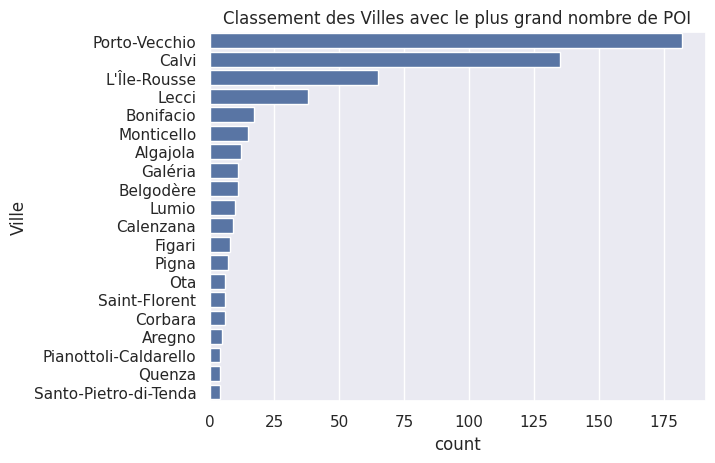

In [84]:
sns.set()
sns.countplot(y="Ville", color = "b", data = df_ML, order=df_ML.Ville.value_counts().iloc[:20].index).set_title('Classement des Villes avec le plus grand nombre de POI');

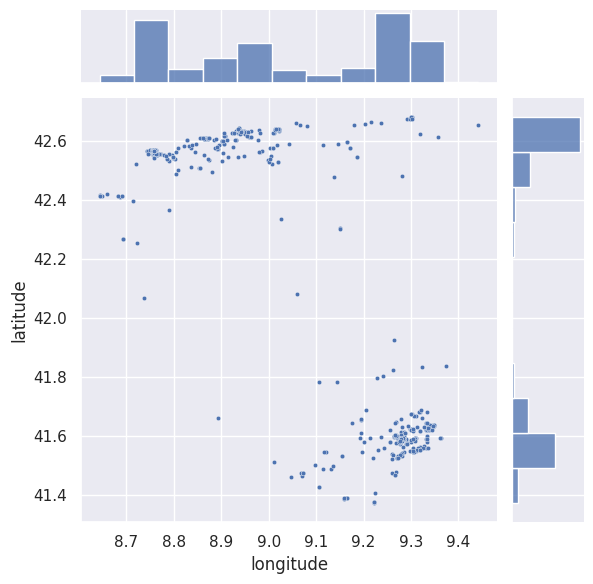

In [143]:
sns.jointplot(x='longitude', y='latitude', data=df_ML, s=10)

In [86]:
df_ML.Departement

@id
https://data.datatourisme.fr/13/000fac17-cff9-3918-a3d6-8edc919c8533     Haute-Corse
https://data.datatourisme.fr/13/016f3145-67f8-33c3-9293-109b420a9104    Corse-du-Sud
https://data.datatourisme.fr/13/018c05e0-d6c7-34b8-b42d-5f29245d99f2     Haute-Corse
https://data.datatourisme.fr/13/019b2930-944c-3019-8e9a-9fa4aaf10797    Corse-du-Sud
https://data.datatourisme.fr/13/0278689c-4ed8-3c84-8877-0e9a86826f8e    Corse-du-Sud
                                                                            ...     
https://data.datatourisme.fr/13/fe353538-c261-34f3-aeca-dac0a0353d50     Haute-Corse
https://data.datatourisme.fr/13/fee026aa-0aa1-3bc8-bf55-c072e332a38f     Haute-Corse
https://data.datatourisme.fr/13/ff22bb83-6515-3e5a-bef4-7c19c38d13d9     Haute-Corse
https://data.datatourisme.fr/13/ffc6590c-e617-33bc-af76-d1f7d487e6fa     Haute-Corse
https://data.datatourisme.fr/13/ffe728c8-9066-38ff-ac86-e25d3d0bdf87     Haute-Corse
Name: Departement, Length: 623, dtype: object

In [236]:
pointoi_gdf = geopandas.GeoDataFrame(df_ML, geometry=geopandas.points_from_xy(df_ML.longitude, df_ML.latitude))

In [237]:
pointoi_gdf = pointoi_gdf.set_crs(epsg=4326)
pointoi_gdf = pointoi_gdf.to_crs(epsg=3857)

In [230]:
ax.get_ylim()

(5057708.234281784, 5320000.278358304)

In [93]:
# west, south, east, north = (8.4045, 41.3149, 9.6899, 43.0809)
# _ = cx.bounds2raster(west, south, east, north,
#                      ll=True,
#                      path="corse.tif",
#                      source=cx.providers.OpenStreetMap.France
#                     )

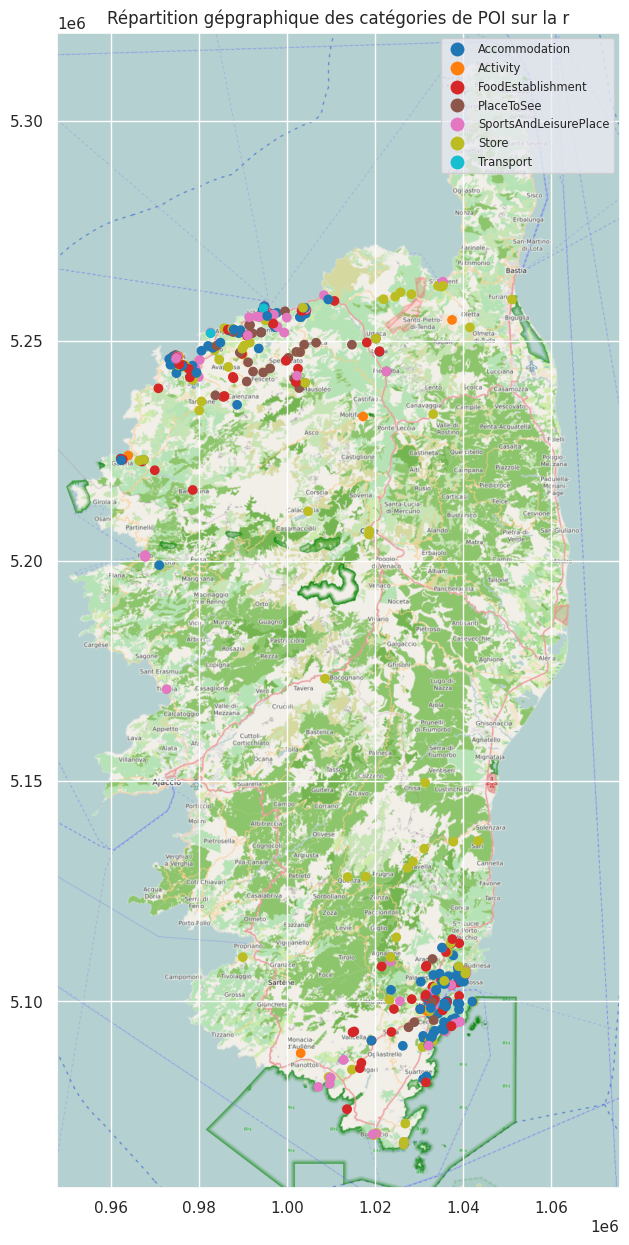

In [238]:
plt.rc('legend', fontsize='x-small')
ax = pointoi_gdf.plot(column='type_2', legend=True, figsize=(15, 15))
ax.set_xlim((947769.4326366666, 1075531.723396394))
ax.set_ylim((5057708.234281784, 5320000.278358304))
cx.add_basemap(ax, source='corse.tif')
plt.title('Répartition gépgraphique des catégories de POI sur la r');

In [240]:
df_ML.to_csv("df_ML.csv")

In [207]:
replace_type_dict = {
    "HolidayResort": "Accommodation",
    "SportsCompetition": "SportsAndLeisurePlace",
    "CampingAndCaravanning": "Accommodation",
    "HotelTrade": "Accommodation",
    "SwimmingPool": "SportsAndLeisurePlace",
    "LodgingBusiness": "Accommodation",
    "WalkingTour": "Activity",
    "ZooAnimalPark": "Activity",
    "Tour": "Activity",
    "TastingProvider": "FoodEstablishment",
    "ReligiousSite": "PlaceToSee",
    "EntertainmentAndEvent": "Activity",
    "District": "PlaceToSee",
    "SquashCourt": "SportsAndLeisurePlace",
    "ThemePark": "Activity",
    "TechnicalHeritage": "PlaceToSee",
    "ParkAndGarden": "PlaceToSee",
    "CollectiveAccommodation": "Accommodation",
    "Ruins": "PlaceToSee",
    "TennisComplex": "SportsAndLeisurePlace",
    "DefenceSite": "PlaceToSee",
    "TouristTrain": "Transport",
    "Transporter": "Transport",
    "CulturalSite": "PlaceToSee"
}

In [208]:
l = df_raw['@type'].map(lambda x: x[-1])

In [209]:
set(map(lambda x: replace_type_dict[x] if x in replace_type_dict.keys() else x, l))

{'Accommodation',
 'Activity',
 'FoodEstablishment',
 'PlaceToSee',
 'SportsAndLeisurePlace',
 'Store',
 'Transport'}

In [211]:
df_raw['@type'].map(lambda x: x[-1]).replace(replace_type_dict)

0                      Store
1      SportsAndLeisurePlace
2                      Store
3                 PlaceToSee
4              Accommodation
               ...          
618    SportsAndLeisurePlace
619    SportsAndLeisurePlace
620        FoodEstablishment
621        FoodEstablishment
622    SportsAndLeisurePlace
Name: @type, Length: 623, dtype: object

In [224]:
df_lastType_2 = df_lastType.replace(replace_type_dict)

In [225]:
df_lastType_2

0                      Store
1      SportsAndLeisurePlace
2                      Store
3                 PlaceToSee
4              Accommodation
               ...          
618    SportsAndLeisurePlace
619    SportsAndLeisurePlace
620        FoodEstablishment
621        FoodEstablishment
622    SportsAndLeisurePlace
Name: @type, Length: 623, dtype: object

In [226]:
df_POI['type_2'] = df_lastType_2

In [227]:
df_POI

,@id,type,lastUpdate,schema:email,schema:telephone,typeContact,foaf:homepage,Description,schema:geo.schema:latitude,schema:geo.schema:longitude,Ville,CodePostale,Departement,Region,Close,Open,validFrom,validThrough,type_2
0,https://data.datatourisme.fr/13/000fac17-cff9-...,Store,2022-08-11,[calvijet@gmail.com],[+33 6 26 17 04 97],"[foaf:Agent, Agent]",[https://www.calvi-jet.fr/],"Lors de vos vacances en corse, les amateurs de...",42.555104,8.761533,Calvi,20260,Haute-Corse,Corse,20:30:00,08:00:00,2023-05-01T00:00:00,2023-10-31T23:59:59,Store
1,https://data.datatourisme.fr/13/016f3145-67f8-...,SportsAndLeisurePlace,2023-04-01,[promenadesdugolfe.ulysse@gmail.com],"[+33 6 15 07 34 68, +33 6 21 09 21 41]","[foaf:Agent, Agent]",[https://www.promenadesdugolfe.com/],Promenades au rythme d'antan à bord d'Ulysse c...,41.590132,9.283183,Porto-Vecchio,20137,Corse-du-Sud,Corse,None,None,2023-01-01T00:00:00,2023-12-31T23:59:59,SportsAndLeisurePlace
2,https://data.datatourisme.fr/13/018c05e0-d6c7-...,Store,2022-07-06,[tourisme@balagne-corsica.com],[+33 4 95 65 16 67],"[foaf:Agent, Agent]",[https://www.balagne-corsica.com/],"En saison, le Bureau d'Information Touristique...",42.568,8.7595,Calvi,20260,Haute-Corse,Corse,None,None,2023-06-06T00:00:00,2023-09-30T23:59:59,Store
3,https://data.datatourisme.fr/13/019b2930-944c-...,CulturalSite,2022-05-20,NaN,[+33 4 95 70 09 58],"[foaf:Agent, Agent]",NaN,"Forteresse cyclopéenne, aux remparts démesurés...",41.656311,9.279691,San-Gavino-di-Carbini,20170,Corse-du-Sud,Corse,None,None,2023-01-01T00:00:00,2023-12-31T23:59:59,PlaceToSee
4,https://data.datatourisme.fr/13/0278689c-4ed8-...,HolidayResort,2023-02-06,[infopalombaggia@gmail.com],[+33 4 95 70 95 70],"[foaf:Agent, Agent]",[http://www.palombaggia.com/],"A 900 mètres de la plage de Palombaggia, résid...",41.564,9.3193,Porto-Vecchio,20137,Corse-du-Sud,Corse,None,None,2023-04-07T00:00:00,2023-11-05T23:59:59,Accommodation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,https://data.datatourisme.fr/13/fe353538-c261-...,SportsAndLeisurePlace,2023-01-23,[info@voce.corsica],"[+33 4 95 61 73 13, +33 6 79 40 68 80]","[foaf:Agent, Agent]",[http://www.voce.corsica/],"Axé sur les musiques(traditionnelles, contempo...",42.59972,8.90297,Pigna,20220,Haute-Corse,Corse,None,None,2023-01-01T00:00:00,2023-12-31T23:59:59,SportsAndLeisurePlace
619,https://data.datatourisme.fr/13/fee026aa-0aa1-...,SportsAndLeisurePlace,2022-09-28,NaN,NaN,NaN,NaN,Venez profiter des plages de Bodri et de Ghjun...,42.627,8.9058,Corbara,20220,Haute-Corse,Corse,None,None,2023-01-01T00:00:00,2023-12-31T23:59:59,SportsAndLeisurePlace
620,https://data.datatourisme.fr/13/ff22bb83-6515-...,FoodEstablishment,2023-02-28,[contact@afuntana.fr],[+33 4 95 65 09 52],"[foaf:Agent, Agent]",[http://www.afuntana.fr/],"Lors de votre séjour en Corse, faites une paus...",42.566999,8.757473,Calvi,20260,Haute-Corse,Corse,None,None,2023-03-01T00:00:00,2023-11-02T23:59:59,FoodEstablishment
621,https://data.datatourisme.fr/13/ffc6590c-e617-...,FoodEstablishment,2022-05-03,NaN,[+33 4 95 65 06 30],"[foaf:Agent, Agent]",NaN,Pause gourmande en Corse ... La Cuisine by Via...,42.566,8.7581,Calvi,20260,Haute-Corse,Corse,None,None,2023-04-01T00:00:00,2023-10-31T23:59:59,FoodEstablishment


In [247]:
df_ML_2 = df_ML[['type_2', 'latitude', 'longitude']]

In [251]:
df_ML_2_dummies = pd.get_dummies(df_ML_2, "type_2", drop_first=True)

In [252]:
df_ML_2_dummies

,latitude,longitude,type_2_Activity,type_2_FoodEstablishment,type_2_PlaceToSee,type_2_SportsAndLeisurePlace,type_2_Store,type_2_Transport
@id,,,,,,,,
https://data.datatourisme.fr/13/000fac17-cff9-3918-a3d6-8edc919c8533,42.555104,8.761533,False,False,False,False,True,False
https://data.datatourisme.fr/13/016f3145-67f8-33c3-9293-109b420a9104,41.590132,9.283183,False,False,False,True,False,False
https://data.datatourisme.fr/13/018c05e0-d6c7-34b8-b42d-5f29245d99f2,42.568000,8.759500,False,False,False,False,True,False
https://data.datatourisme.fr/13/019b2930-944c-3019-8e9a-9fa4aaf10797,41.656311,9.279691,False,False,True,False,False,False
https://data.datatourisme.fr/13/0278689c-4ed8-3c84-8877-0e9a86826f8e,41.564000,9.319300,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
https://data.datatourisme.fr/13/fe353538-c261-34f3-aeca-dac0a0353d50,42.599720,8.902970,False,False,False,True,False,False
https://data.datatourisme.fr/13/fee026aa-0aa1-3bc8-bf55-c072e332a38f,42.627000,8.905800,False,False,False,True,False,False
https://data.datatourisme.fr/13/ff22bb83-6515-3e5a-bef4-7c19c38d13d9,42.566999,8.757473,False,True,False,False,False,False


In [268]:
kmeans = KMeans(n_clusters=20)

In [269]:
kmeans.fit(df_ML_2_dummies)

/mnt/c/Users/tfavr/itvacances/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=20)

In [270]:
df_ML_2_dummies['label'] = kmeans.labels_

In [260]:
kmeans.labels_

array([3, 4, 3, 1, 1, 2, 7, 1, 3, 2, 3, 2, 0, 2, 2, 5, 2, 1, 1, 0, 1, 2,
       7, 1, 7, 3, 3, 2, 1, 3, 1, 2, 1, 1, 4, 6, 2, 2, 0, 0, 6, 0, 3, 4,
       0, 0, 1, 1, 2, 3, 2, 6, 0, 6, 1, 6, 2, 5, 3, 7, 1, 7, 2, 2, 0, 1,
       1, 7, 0, 7, 6, 3, 5, 7, 2, 7, 1, 0, 7, 7, 2, 2, 2, 2, 4, 0, 6, 0,
       3, 2, 5, 1, 2, 2, 3, 6, 2, 5, 0, 4, 0, 1, 4, 0, 6, 2, 2, 2, 2, 4,
       1, 0, 6, 5, 2, 2, 2, 2, 6, 1, 2, 2, 2, 1, 3, 5, 2, 7, 0, 3, 3, 0,
       0, 3, 5, 0, 3, 7, 6, 7, 1, 1, 7, 5, 0, 3, 0, 1, 6, 1, 1, 5, 5, 5,
       1, 7, 6, 6, 3, 4, 6, 2, 0, 5, 3, 6, 3, 1, 6, 3, 4, 2, 2, 2, 3, 1,
       5, 5, 2, 7, 2, 1, 5, 2, 5, 6, 3, 1, 4, 2, 1, 7, 1, 3, 4, 0, 0, 2,
       1, 1, 0, 2, 6, 7, 7, 4, 2, 0, 2, 2, 4, 2, 1, 1, 2, 5, 1, 5, 0, 0,
       5, 1, 0, 6, 7, 6, 0, 6, 2, 0, 3, 7, 6, 3, 2, 0, 0, 5, 4, 2, 1, 3,
       3, 2, 5, 3, 3, 1, 6, 1, 6, 5, 4, 5, 7, 6, 0, 1, 7, 0, 5, 5, 1, 3,
       1, 0, 0, 0, 2, 6, 5, 2, 3, 1, 0, 3, 1, 2, 1, 2, 2, 4, 2, 3, 2, 6,
       3, 7, 7, 2, 3, 7, 0, 3, 3, 1, 0, 3, 6, 2, 0,

In [257]:
df_ML_2_dummies

,latitude,longitude,type_2_Activity,type_2_FoodEstablishment,type_2_PlaceToSee,type_2_SportsAndLeisurePlace,type_2_Store,type_2_Transport,label
@id,,,,,,,,,
https://data.datatourisme.fr/13/000fac17-cff9-3918-a3d6-8edc919c8533,42.555104,8.761533,False,False,False,False,True,False,3
https://data.datatourisme.fr/13/016f3145-67f8-33c3-9293-109b420a9104,41.590132,9.283183,False,False,False,True,False,False,4
https://data.datatourisme.fr/13/018c05e0-d6c7-34b8-b42d-5f29245d99f2,42.568000,8.759500,False,False,False,False,True,False,3
https://data.datatourisme.fr/13/019b2930-944c-3019-8e9a-9fa4aaf10797,41.656311,9.279691,False,False,True,False,False,False,1
https://data.datatourisme.fr/13/0278689c-4ed8-3c84-8877-0e9a86826f8e,41.564000,9.319300,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...
https://data.datatourisme.fr/13/fe353538-c261-34f3-aeca-dac0a0353d50,42.599720,8.902970,False,False,False,True,False,False,7
https://data.datatourisme.fr/13/fee026aa-0aa1-3bc8-bf55-c072e332a38f,42.627000,8.905800,False,False,False,True,False,False,7
https://data.datatourisme.fr/13/ff22bb83-6515-3e5a-bef4-7c19c38d13d9,42.566999,8.757473,False,True,False,False,False,False,0


In [272]:
pointoi_gdf_2 = geopandas.GeoDataFrame(df_ML_2_dummies, geometry=geopandas.points_from_xy(df_ML_2_dummies.longitude, df_ML_2_dummies.latitude))

In [273]:
pointoi_gdf_2 = pointoi_gdf_2.set_crs(epsg=4326)
pointoi_gdf_2 = pointoi_gdf_2.to_crs(epsg=3857)

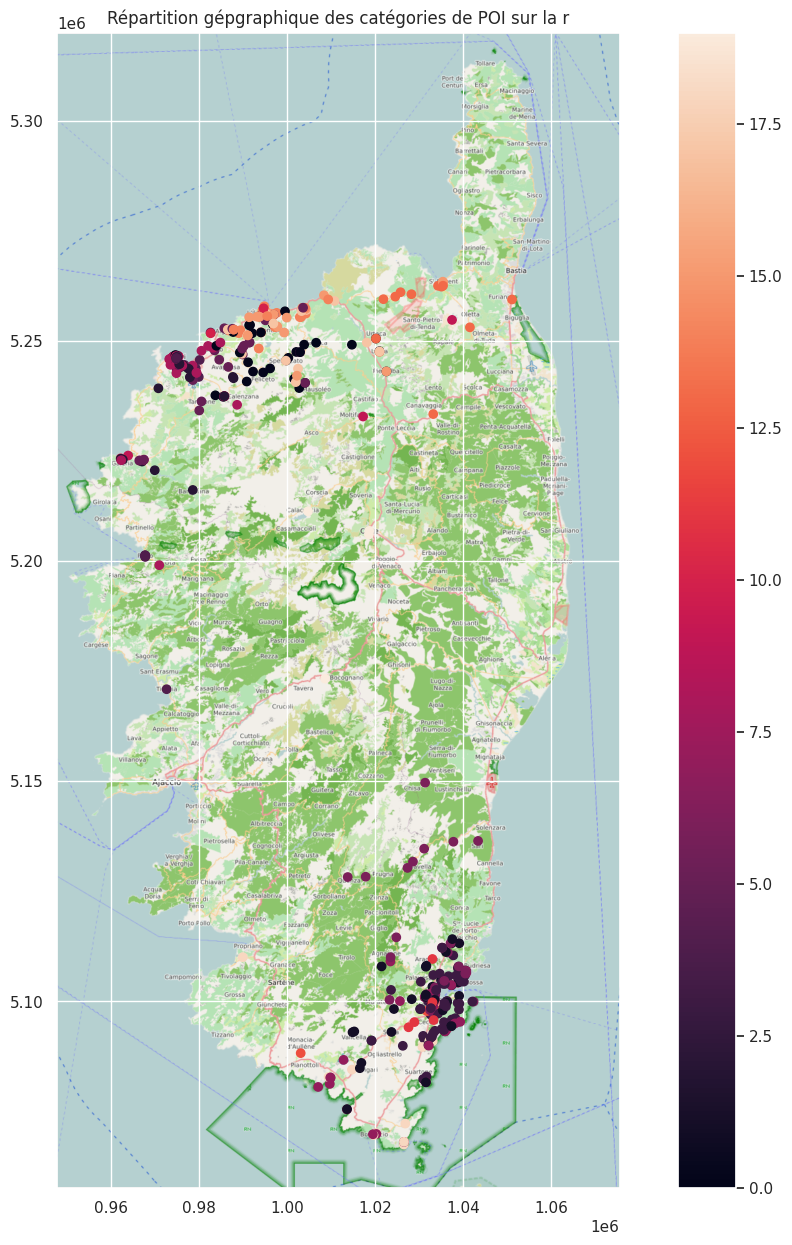

In [274]:
plt.rc('legend', fontsize='x-small')
ax = pointoi_gdf_2.plot(column='label', legend=True, figsize=(15, 15))
ax.set_xlim((947769.4326366666, 1075531.723396394))
ax.set_ylim((5057708.234281784, 5320000.278358304))
cx.add_basemap(ax, source='corse.tif')
plt.title('Répartition gépgraphique des catégories de POI sur la r');